In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
import requests # package for getting data from the web
from zipfile import * # package for unzipping zip files

In [2]:
# Import the get_engine function from our sql_functions.
from sql_functions import get_engine #adjust this as necessary to match your sql_functions.py connection methods

In [3]:
# Specifies path for saving file
path ='data/' 
# Create the data folder
!mkdir {path}

mkdir: data/: File exists


In [4]:
# function to get specified csv file from the website https://transtats.bts.gov

def download_data(year, month ):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
    # Download the database
    r = requests.get(f'{url}', verify=False)
    # Save database to local file storage
    with open(path+zip_file, 'wb') as f:
        f.write(r.content)
        print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )
    

In [5]:
# function to get specified csv file from the website https://transtats.bts.gov

def download_data(year, month ):
    # Get the file from the website https://transtats.bts.gov
    zip_file = f'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip'
    url = (f'https://transtats.bts.gov/PREZIP/{zip_file}')
    # Download the database
    r = requests.get(f'{url}', verify=False)
    # Save database to local file storage
    with open(path+zip_file, 'wb') as f:
        f.write(r.content)
        print(f'--> zip_file with name: {zip_file} downloaded succesfully.' )


In [6]:
years_list = [2010] # list of years you want to look at (can of course also be a single year)
months_list = [2] # list of months you want to look at (can of course also be a single month)

# download flights data as zipfile(s)
# we use a nested loop to specify the years and months to define the range of the data we would like to have 
for year in years_list:
    for month in months_list:
        download_data(year, month)
        extract_zip(year, month)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/urllib3/connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


--> zip_file with name: On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2010_2.zip downloaded succesfully.


NameError: name 'extract_zip' is not defined

In [7]:
# define the name of the csv file you want to read in
csv_file = 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2010_2.csv'

# Read in your data
df = pd.read_csv(path+csv_file, low_memory = False)
display(df.shape)
display(df.head())

(483270, 110)

,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,Tail_Number,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Unnamed: 109
0,2010,1,2,2,2,2010-02-02,WN,19393,WN,N907WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010,1,2,2,2,2010-02-02,WN,19393,WN,N270WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010,1,2,2,2,2010-02-02,WN,19393,WN,N357SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010,1,2,2,2,2010-02-02,WN,19393,WN,N918WN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010,1,2,2,2,2010-02-02,WN,19393,WN,N355SW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Columns from downloaded file that are to be kept
columns_to_keep = [
                'FlightDate',
                'DepTime',
                'CRSDepTime',
                'DepDelay',
                'ArrTime',
                'CRSArrTime',
                'ArrDelay',
                'Reporting_Airline',
                'Tail_Number',
                'Flight_Number_Reporting_Airline',
                'Origin',
                'Dest',
                'AirTime',
                'ActualElapsedTime',
                'Distance',
                'Cancelled',
                'Diverted'
]

In [9]:
# Import the get_engine function from our sql_functions.
from sql_functions import get_engine #adjust this as necessary to match your sql_functions.py connection methods

In [10]:
# The columns in the database have different naming as in the source csv files. Lets get the names from the database

schema = 'hh_analytics_24_1' # UPDATE 'TABLE_SCHEMA' based on schema used in class 
engine = get_engine() # assign engine to be able to query against the database

table_name_sql = f'''SELECT COLUMN_NAME 
                    FROM INFORMATION_SCHEMA.COLUMNS 
                    WHERE TABLE_NAME = 'flights'
                    AND TABLE_SCHEMA ='{schema}'
                    ORDER BY ordinal_position'''
c_names = engine.execute(table_name_sql).fetchall()
c_names

[('flight_date',),
 ('dep_time',),
 ('sched_dep_time',),
 ('dep_delay',),
 ('arr_time',),
 ('sched_arr_time',),
 ('arr_delay',),
 ('airline',),
 ('tail_number',),
 ('flight_number',),
 ('origin',),
 ('dest',),
 ('air_time',),
 ('actual_elapsed_time',),
 ('distance',),
 ('cancelled',),
 ('diverted',)]

In [11]:
# we can clean up the results into a clean list
new_column_names=[]
for name in c_names:
    new_column_names.append(name[0])
new_column_names        

['flight_date',
 'dep_time',
 'sched_dep_time',
 'dep_delay',
 'arr_time',
 'sched_arr_time',
 'arr_delay',
 'airline',
 'tail_number',
 'flight_number',
 'origin',
 'dest',
 'air_time',
 'actual_elapsed_time',
 'distance',
 'cancelled',
 'diverted']

In [12]:
def clean_airline_df(df):
    '''
    Transforms a df made from BTS csv file into a df that is ready to be uploaded to SQL
    Set rows=0 for no filtering
    '''

    # Build dataframe including only the columns you want to keep
    df_airline = df.loc[:,columns_to_keep]
     
    # Clean data types and NULLs
    df_airline['FlightDate']= pd.to_datetime(df_airline['FlightDate'], yearfirst=True)
    df_airline['CRSArrTime']= pd.to_numeric(df_airline['CRSArrTime'], downcast='integer', errors='coerce')
    df_airline['Cancelled']= pd.to_numeric(df_airline['Cancelled'], downcast='integer')
    df_airline['Diverted']= pd.to_numeric(df_airline['Diverted'], downcast='integer')
    df_airline['ActualElapsedTime']= pd.to_numeric(df_airline['ActualElapsedTime'], downcast='integer', errors='coerce')
    
    # Rename columns
    df_airline.columns = new_column_names
    
    return df_airline

In [13]:
# Call function and check resulting dataframe
df_clean = clean_airline_df(df)
df_clean.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
0,2010-02-02,830.0,830,0.0,842.0,900,-18.0,WN,N907WN,334,CLE,MDW,60.0,72.0,307.0,0,0
1,2010-02-02,1129.0,1135,-6.0,1134.0,1200,-26.0,WN,N270WN,356,CLE,MDW,55.0,65.0,307.0,0,0
2,2010-02-02,1424.0,1420,4.0,1443.0,1440,3.0,WN,N357SW,967,CLE,MDW,54.0,79.0,307.0,0,0
3,2010-02-02,625.0,635,-10.0,639.0,705,-26.0,WN,N918WN,1945,CLE,MDW,61.0,74.0,307.0,0,0
4,2010-02-02,1930.0,1820,70.0,1933.0,1845,48.0,WN,N355SW,2624,CLE,MDW,51.0,63.0,307.0,0,0


In [14]:
# Specify the airports you are interested in and put them as a list in the function.
def select_airport(df, airports):
    ''' Helper function for filtering the airline dataframe for a subset of airports'''
    df_out = df.loc[(df.origin.isin(airports)) | (df.dest.isin(airports))]
    return df_out

In [15]:
# Execute function, filtering for New York area airports
airports=['DCA', 'IAD', 'BWI', 'PHL', 'EWR', 'JFK', 'LGA']
if len(airports) > 0:
    df_selected_airports = select_airport(df_clean, airports)
else:
    df_selected_airports = df_clean
    
df_selected_airports.head()

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,origin,dest,air_time,actual_elapsed_time,distance,cancelled,diverted
8,2010-02-02,1825.0,1830,-5.0,1926.0,1945,-19.0,WN,N257WN,484,CMH,BWI,50.0,61.0,336.0,0,0
9,2010-02-02,1047.0,1025,22.0,1153.0,1135,18.0,WN,N308SA,801,CMH,BWI,52.0,66.0,336.0,0,0
10,2010-02-02,1331.0,1335,-4.0,1434.0,1445,-11.0,WN,N751SW,1480,CMH,BWI,52.0,63.0,336.0,0,0
11,2010-02-02,638.0,630,8.0,749.0,740,9.0,WN,N942WN,3137,CMH,BWI,50.0,71.0,336.0,0,0
176,2010-02-02,949.0,955,-6.0,1453.0,1515,-22.0,WN,N799SW,146,DEN,BWI,173.0,184.0,1491.0,0,0


In [16]:
# Specify which table within your database you want to push your data to. Give your table an unambiguous name.
# Example: flights_sp for Sina's flights table, flights_groupname or similar
table_name = 'flights_api_rr'
# If the specified table doesn't exist yet, it will be created
# With 'replace', your data will be replaced if the table already exists.
# This may take some time ...

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        df_selected_airports.to_sql(name=table_name, # Name of SQL table
                        con=engine, # Engine or connection
                        if_exists='replace', # Drop the table before inserting new values 
                        schema=schema, # Use schmea that was defined earlier
                        index=False, # Write DataFrame index as a column
                        chunksize=5000, # Specify the number of rows in each batch to be written at a time
                        method='multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None

The flights_api_rr table was imported successfully.


In [18]:
# Just to be sure: Check if the number of rows match
table_name_sql = f'''SELECT count(*) 
                    FROM {schema}.{table_name}
                    '''
engine.execute(table_name_sql).fetchall()[0][0] == df_selected_airports.shape[0]

True

In [1]:
from sql_functions import get_dataframe

In [12]:
from dotenv import dotenv_values
import sqlalchemy 


In [1]:
schema = 'hh_analytics_24_1' # UPDATE 'TABLE_SCHEMA' based on schema used in class 

In [4]:
schema = 'hh_analytics_24_1'

sql_query = f'SELECT * FROM {schema}.flights_group_x_rr'
flights = get_dataframe(sql_query)

flights.head(20)

,flight_date,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,airline,tail_number,flight_number,...,air_time,actual_elapsed_time,distance,cancelled,diverted,lat,lon,city,tz_origin,tz_dest
0,2010-02-02,1825.0,1830,-5.0,1926.0,1945,-19.0,WN,N257WN,484,...,50.0,61.0,336.0,0,0,39.998001,-82.891899,Columbus,-5.0,-5.0
1,2010-02-02,1047.0,1025,22.0,1153.0,1135,18.0,WN,N308SA,801,...,52.0,66.0,336.0,0,0,39.998001,-82.891899,Columbus,-5.0,-5.0
2,2010-02-02,1331.0,1335,-4.0,1434.0,1445,-11.0,WN,N751SW,1480,...,52.0,63.0,336.0,0,0,39.998001,-82.891899,Columbus,-5.0,-5.0
3,2010-02-02,638.0,630,8.0,749.0,740,9.0,WN,N942WN,3137,...,50.0,71.0,336.0,0,0,39.998001,-82.891899,Columbus,-5.0,-5.0
4,2010-02-02,949.0,955,-6.0,1453.0,1515,-22.0,WN,N799SW,146,...,173.0,184.0,1491.0,0,0,39.861698,-104.672997,Denver,-7.0,-5.0
5,2010-02-02,1802.0,1805,-3.0,2320.0,2320,0.0,WN,N401WN,204,...,175.0,198.0,1491.0,0,0,39.861698,-104.672997,Denver,-7.0,-5.0
6,2010-02-02,1339.0,1345,-6.0,1841.0,1900,-19.0,WN,N743SW,242,...,170.0,182.0,1491.0,0,0,39.861698,-104.672997,Denver,-7.0,-5.0
7,2010-02-02,908.0,910,-2.0,1424.0,1455,-31.0,WN,N927WN,1305,...,183.0,196.0,1557.0,0,0,39.861698,-104.672997,Denver,-7.0,-5.0
8,2010-02-02,1800.0,1805,-5.0,2318.0,2335,-17.0,WN,N225WN,2539,...,181.0,198.0,1557.0,0,0,39.861698,-104.672997,Denver,-7.0,-5.0
9,2010-02-02,1248.0,1245,3.0,1813.0,1830,-17.0,WN,N792SW,3397,...,172.0,205.0,1557.0,0,0,39.861698,-104.672997,Denver,-7.0,-5.0


In [5]:
flights[['cancelled', 'diverted', 'flight_date']].groupby('flight_date').sum()


,cancelled,diverted
flight_date,,
2010-02-01,39,2
2010-02-02,81,2
2010-02-03,85,7
2010-02-04,18,7
2010-02-05,1039,15
2010-02-06,1539,9
2010-02-07,1309,5
2010-02-08,501,7
2010-02-09,1086,8


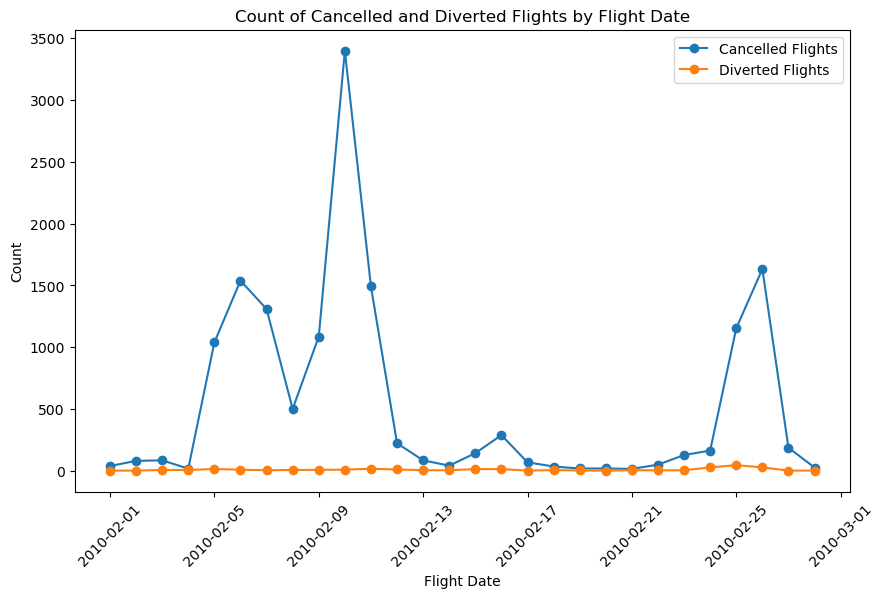

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing flight_date, cancelled, and diverted columns

# Convert flight_date to datetime if it's not already in datetime format
flights['flight_date'] = pd.to_datetime(flights['flight_date'])

# Group by flight_date and aggregate counts of cancelled and diverted flights
agg_flights = flights.groupby('flight_date').agg({'cancelled': 'sum', 'diverted': 'sum'}).reset_index()

# Plot the counts
plt.figure(figsize=(10, 6))
plt.plot(agg_flights['flight_date'], agg_flights['cancelled'], label='Cancelled Flights', marker='o')
plt.plot(agg_flights['flight_date'], agg_flights['diverted'], label='Diverted Flights', marker='o')

# Add labels and title
plt.xlabel('Flight Date')
plt.ylabel('Count')
plt.title('Count of Cancelled and Diverted Flights by Flight Date')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Show plot
plt.show()